In [5]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NaiveSeasonal, NBEATSModel, ARIMA, TFTModel, RandomForest
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality
from darts.metrics import smape
from statsmodels.tsa.seasonal import seasonal_decompose
from darts.utils.statistics import plot_residuals_analysis
from darts.dataprocessing.transformers import Scaler
import optuna
from pytorch_lightning.callbacks import EarlyStopping

/opt/miniconda3/envs/sales/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Injestion

In [6]:
pkl_dir = Path(Path.cwd().parent, "data", "interim", "exploration_df.pkl")
df = pd.read_pickle(pkl_dir)

In [7]:
df = df.set_index('date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype    
---  ------      --------------   -----    
 0   store       913000 non-null  int64    
 1   item        913000 non-null  int64    
 2   sales       913000 non-null  int64    
 3   day         913000 non-null  int64    
 4   month       913000 non-null  int64    
 5   year        913000 non-null  int64    
 6   quarter     913000 non-null  int64    
 7   month_year  913000 non-null  period[M]
 8   month_name  120 non-null     object   
dtypes: int64(7), object(1), period[M](1)
memory usage: 69.7+ MB


In [8]:
df.head()

,store,item,sales,day,month,year,quarter,month_year,month_name
date,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,2013-01,Jan
2013-01-02,1,1,11,2,1,2013,1,2013-01,Feb
2013-01-03,1,1,14,3,1,2013,1,2013-01,Mar
2013-01-04,1,1,13,4,1,2013,1,2013-01,Apr
2013-01-05,1,1,10,5,1,2013,1,2013-01,May


# Creating a darts timeseries

In [9]:
series_group = TimeSeries.from_group_dataframe(df, 
                                group_cols = ['store', 'item'], 
                    time_col=None, 
                    value_cols='sales', 
                    static_cols=None, 
                    fill_missing_dates=False, 
                    freq='D', 
                    fillna_value=None)

In [10]:
len(series_group)
# one series for each store and product = 10* 50 = 500

500

# Testing first series

In [11]:
single_series = series_group[1] #store 1 item 1
single_series.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)>
array([[[33.]],

       [[43.]],

       [[23.]],

       [[18.]],

       [[34.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-05
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store  item\ncomponent            ...
    hierarchy:          None

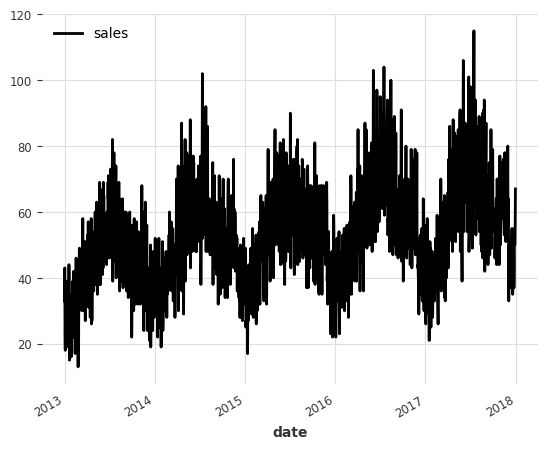

In [12]:
single_series.plot()

# Decomposition

In [9]:
single_df = df[(df['store'] == 1) & (df['item'] == 1)]

With statsmodels we can decompose the sales for a single store and item into seasonal and trend components. 

<Figure size 640x480 with 0 Axes>

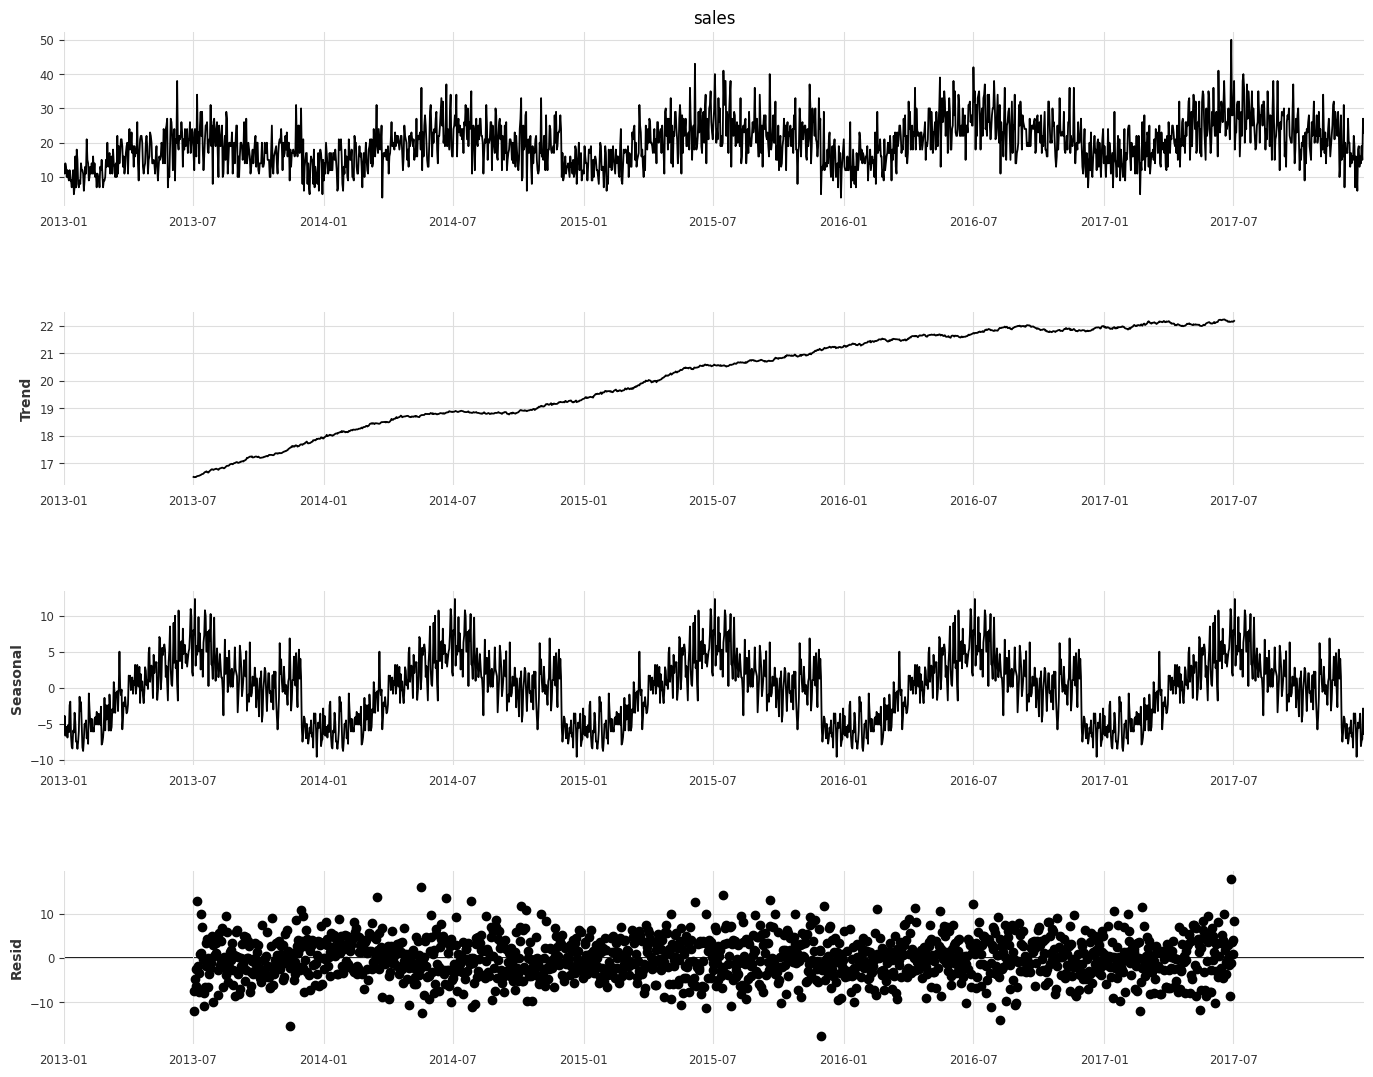

In [10]:
result = seasonal_decompose(single_df['sales'], model='additive', period = 365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

# ACF and PACF

We can test for seasonality by plotting the auto-correlation function (ACF). As it looks like we have yearly seasons, we can check at m = 12. 

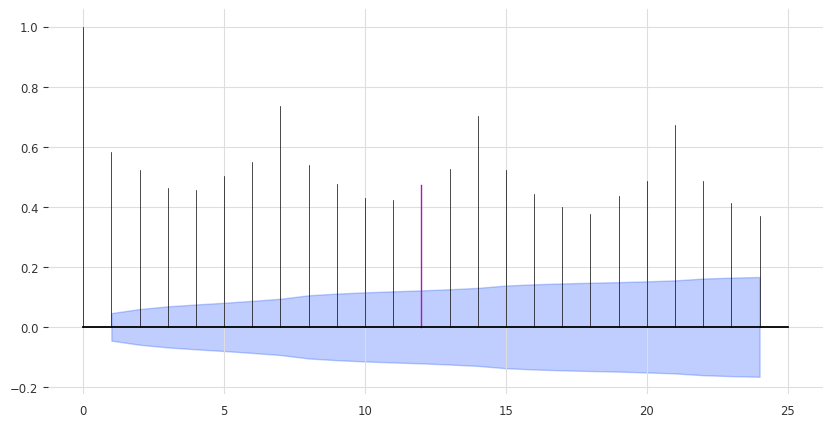

In [11]:
plot_acf(single_series, m=12, alpha=0.05)

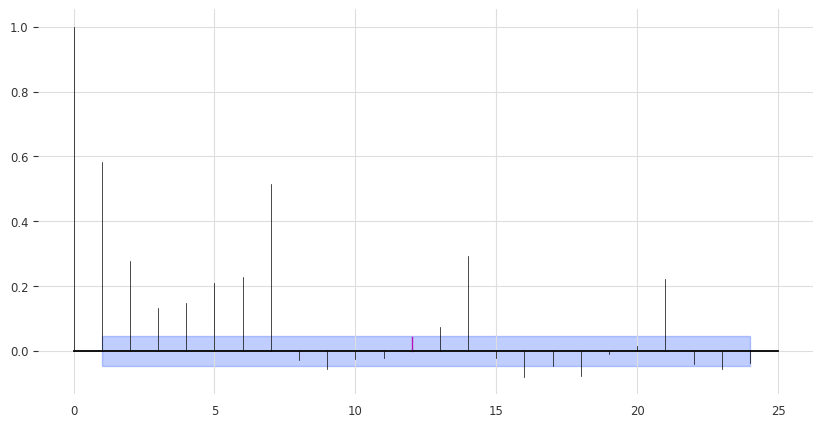

In [12]:
plot_pacf(single_series, m=12, alpha=0.05)

The ACF and PACF present a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red).
Although interestingly there seems to be stronger correlation at x = 7 which is indicative of a weekly trend. 
 The blue zone determines the significance of the statistics for a confidence level of 95%. 

# Basic forecasting

Testing some naive forecasting methods. 
First we need to split intro train/test.

## Train test split

In [31]:
train, val = single_series.split_after(0.75)
len(train), len(val)

(1369, 457)

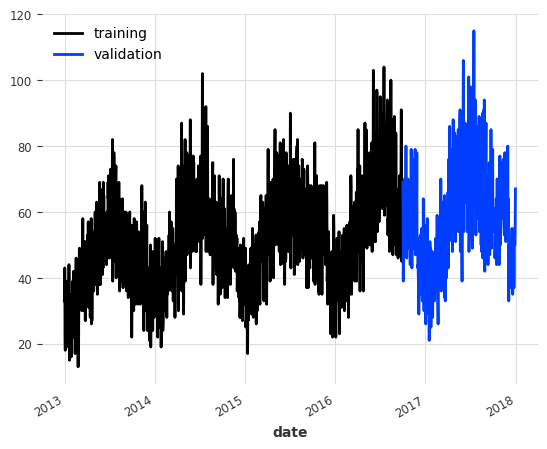

In [32]:
train.plot(label="training")
val.plot(label="validation")

First we'll test a naive seasonal model. 
This is useful to get an idea of the bare minimum accuracy that one could expect. For example, the NaiveSeasonal(K) model always “repeats” the value that occured K time steps ago.

In its most naive form, when K=1, this model simply always repeats the last value of the training series:

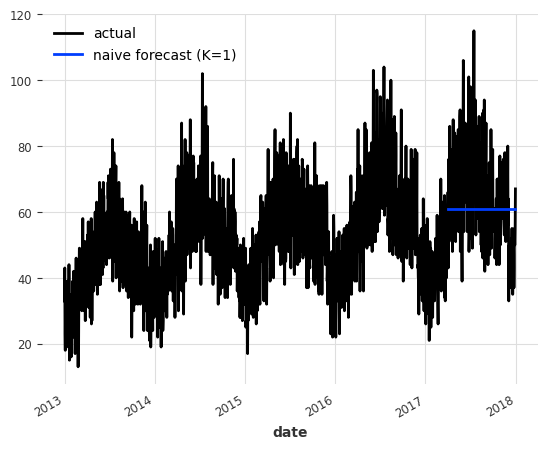

In [14]:
LAG = 1
seasonal_model = NaiveSeasonal(K=LAG) #Based on the acf results above
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

single_series.plot(label="actual")
seasonal_forecast.plot(label=f"naive forecast (K={LAG})",)

For this basic model I'm going to use symmetric Mean Absolute Percentage Error (SMAPE), as this is the metric used in the original kaggle competition. 

In [15]:
print(f"The SMAPE assosciated with the naive seasonal model with no lag is: {smape(single_series, seasonal_forecast):.2f}")

The SMAPE assosciated with the naive seasonal model with no lag is: 18.09


Let's try another seasonal naive model with a yearly lag. 

The SMAPE assosciated with the naive seasonal model is: 19.91


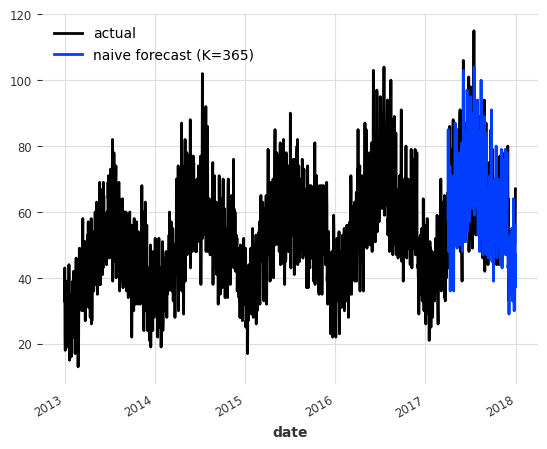

In [16]:
LAG = 365
seasonal_model = NaiveSeasonal(K=LAG) #Based on the acf results above
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

single_series.plot(label="actual")
seasonal_forecast.plot(label=f"naive forecast (K={LAG})",)

print(f"The SMAPE assosciated with the naive seasonal model is: {smape(single_series, seasonal_forecast):.2f}")

The SMAPE has increased, however the general model shape seems to make more sense. 

We can investigate residuals from the models with darts plot_residuals_analysis()

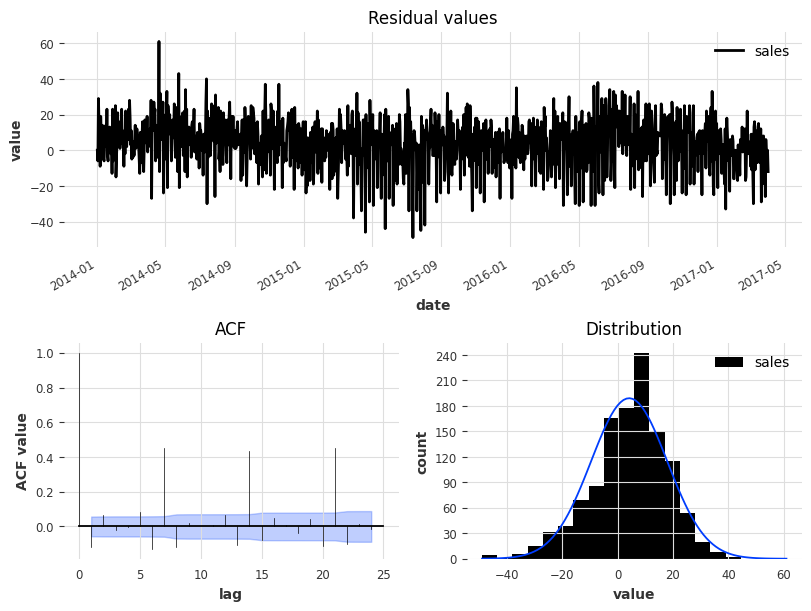

In [17]:
plot_residuals_analysis(seasonal_model.residuals(train))

These graphs show that the naïve method produces forecasts that appear to account for all available information. The mean of the residuals is close to zero and there is no significant correlation in the residuals series. 

 The time plot of the residuals shows that the variation of the residuals stays much the same across the historical data, apart from the one outlier, and therefore the residual variance can be treated as constant. This can also be seen on the histogram of the residuals. 

 

Lets try some more advanced models.

# ARIMA

As ARIMA models are only good for stationary data, we should check this first.
 Stationary means that the mean, standard deviation, and variance don't change over time. 

In [18]:
check_seasonality(train)

(True, 7)

As predicted by the acf and pacf plots, the data is stationary with periodicity 7.

## Basic ARIMA

In [19]:
model_aarima = ARIMA(p = 7, q = 52)
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

single_series.plot(label="actual")
prediction_aarima.plot(label=f"ARIMA Model")

print(f"SMAPE for the ARIMA model is : \
{smape(single_series,prediction_aarima):.2f}")

KeyboardInterrupt: 

The SMAPE value is higher and the ARIMA model doesnt seem to have captured the data very well. 

# Exponential smoothing

The mean squared error assosciated with the exponential smoothing model is: 23.93


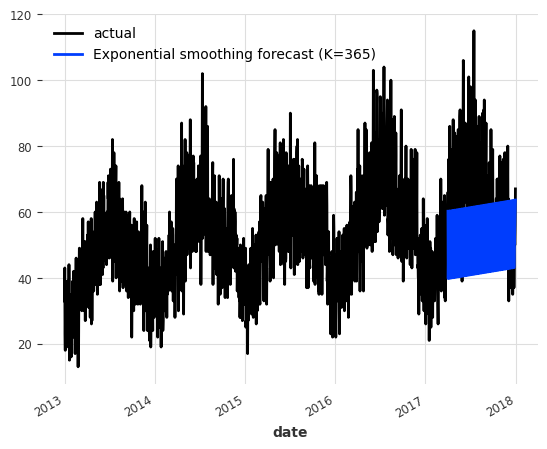

In [ ]:
model_es = ExponentialSmoothing(seasonal_periods=7)
model_es.fit(train)
es_forecast = model_es.predict(len(val))

single_series.plot(label="actual")
es_forecast.plot(label=f"Exponential smoothing forecast (K={LAG})",)

print(f"The mean squared error assosciated with the exponential smoothing model is: {smape(single_series, es_forecast):.2f}")

Higher SMAPE score but has captured the trend better than ARIMA

# ML models

## Preprocessing

We need to scale the data between 0 and 1 for most ML algorithms to perform well. 

In [17]:
df.head()

,store,item,sales,day,month,year,quarter,month_year,month_name
date,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,2013-01,Jan
2013-01-02,1,1,11,2,1,2013,1,2013-01,Feb
2013-01-03,1,1,14,3,1,2013,1,2013-01,Mar
2013-01-04,1,1,13,4,1,2013,1,2013-01,Apr
2013-01-05,1,1,10,5,1,2013,1,2013-01,May


In [18]:
scaler = Scaler()
train_scaled = scaler.fit_transform(train)

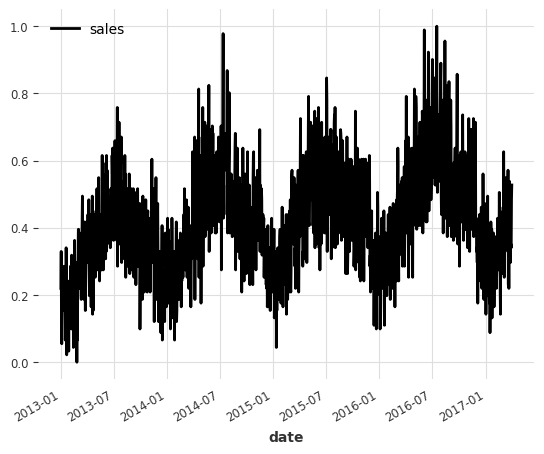

In [19]:
train_scaled.plot()

## N-BEATS

For simplicity, we will keep most of the hyperparameters of the N-BEATS model as default. 
We will jut adjust: 
* input_chunk_length: this is the “lookback window” of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.

* output_chunk_length: this is the “forward window” of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

We need to make sure the input length is at least the length of one year to capture the whole seasonality trend. 

In [ ]:
single_df.groupby('year').count()['store']

year
2013    365
2014    365
2015    365
2016    366
2017    365
Name: store, dtype: int64

365 points per year. Therefore we need an input chunk of 365.

In [ ]:
RUN_N_BEATS = False #Flag to stop this acidentally running, takes 15 mins
if RUN_N_BEATS:
    model = NBEATSModel(input_chunk_length=365, output_chunk_length=30, random_state=42)
    model.fit([train_scaled], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.9 M 
---------------------------------------------------
8.9 M     Trainable params
3.5 K     Non-trainable params
8.9 M     Total params
71.043    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 37/37 [00:11<00:00,  3.23it/s, loss=0.00586, train_loss=0.0041] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 37/37 [00:11<00:00,  3.22it/s, loss=0.00586, train_loss=0.0041]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
mean squared error for N-BEATS: 13.41


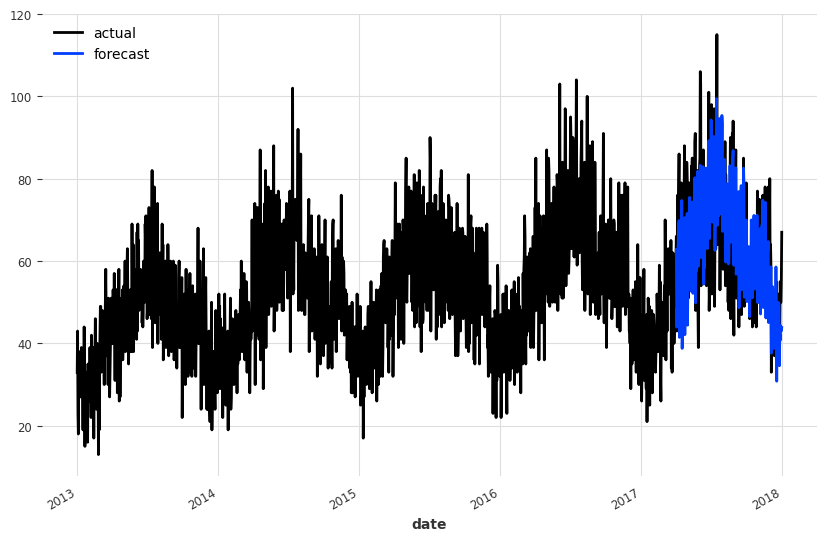

In [ ]:
if RUN_N_BEATS:
    pred = model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)

    plt.figure(figsize=(10, 6))
    single_series.plot(label="actual")
    pred.plot(label="forecast")

    print(f"mean squared error for N-BEATS: {smape(single_series, pred):.2f}")

N Beats has defnitely performed the best so far, with the lowest smape and capturing the data trends well. 

# Temporal Fusion Transformer (TFT)

In [ ]:
RUN_TFT = False #Flag to stop this acidentally running, takes 15 mins
if RUN_TFT:
    model = TFTModel(input_chunk_length=365, 
                     output_chunk_length=30, 
                     random_state=42, 
                     add_relative_index = True)
    model.fit([train_scaled], epochs=50, verbose=True);

Epoch 0:  24%|██▍       | 9/37 [01:24<04:21,  9.35s/it, loss=3.8, train_loss=2.930]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 1.1 K 
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 528   
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont


Epoch 49: 100%|██████████| 37/37 [00:16<00:00,  2.26it/s, loss=0.483, train_loss=0.535]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 37/37 [00:16<00:00,  2.26it/s, loss=0.483, train_loss=0.535]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
mean squared error for TFT: 22.87


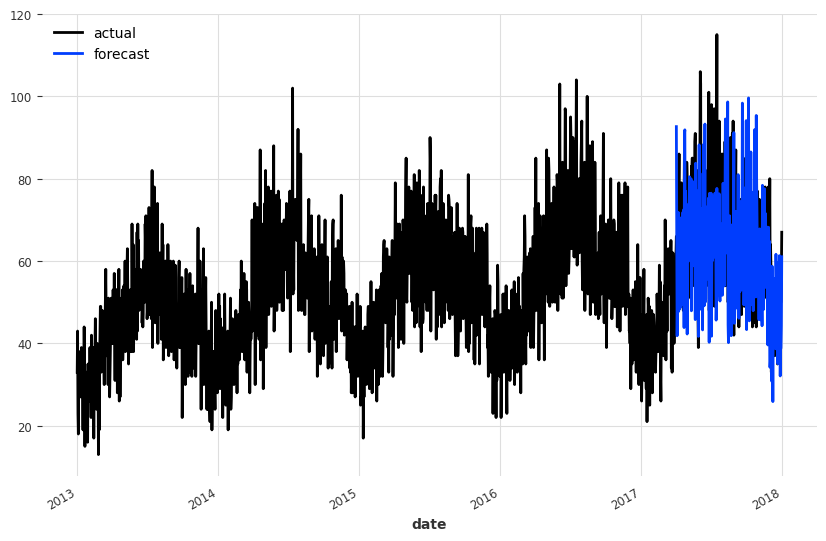

In [ ]:
pred = model.predict(series=train_scaled, n=len(val))
# scale back:
pred= scaler.inverse_transform(pred)

plt.figure(figsize=(10, 6))
single_series.plot(label="actual")
pred.plot(label="forecast")

print(f"mean squared error for TFT: {smape(single_series, pred):.2f}")

Not quite as good as the N-BEATS model, especially around the seasonal peak seen in summer. 

# Randomforest

Random forests, especially XGBoost, are typically high performers for typical ML projects. 

mean squared error for RandomForest: 12.05


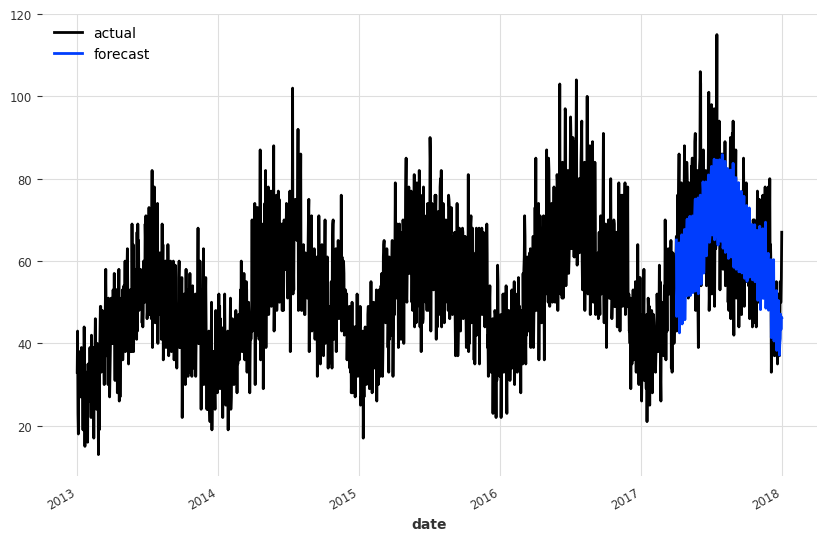

In [ ]:
model = RandomForest(lags = 365)
model.fit(train_scaled);
pred = model.predict(series=train_scaled, n=len(val))
# scale back:
pred= scaler.inverse_transform(pred)

plt.figure(figsize=(10, 6))
single_series.plot(label="actual")
pred.plot(label="forecast")

print(f"mean squared error for RandomForest: {smape(single_series, pred):.2f}")

Although generating a lower smape, the overall fit of the data doesnt see to be as robust as the N-BEATS or TFT models. 

# N-BEATS Model Tuning

As the N-BEATS model has performed the best so far, I'm going to tune this only. 

I'm using Optuna for hyperparameter tuning as it is much smarter/quicker than gridsearch. 

In [34]:
def objective(trial):
    input_chunk_length = trial.suggest_int('input_chunk_length',7,365)
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [early_stopper]
    pl_trainer_kwargs = {"callbacks": callbacks}
    N_BEATS_model = NBEATSModel(input_chunk_length=input_chunk_length, 
                                output_chunk_length=30, 
                                random_state=42, 
                                pl_trainer_kwargs=pl_trainer_kwargs)
    N_BEATS_model.fit(train_scaled,val_series = val, epochs=100, verbose=True);
    
    pred = N_BEATS_model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)
    smape_result = smape(single_series, pred)
    print(f"SMAPE: {smape_result}")
    return smape_result

In [35]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [36]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, callbacks=[print_callback])

[I 2022-11-20 21:13:52,232] A new study created in memory with name: no-name-c1ffc53d-97e2-4328-9495-32f4b9270607
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.4 M 
---------------------------------------------------
8.4 M     Trainable params
3.1 K     Non-trainable params
8.4 M     Total params
66.893    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 44/44 [00:11<00:00,  3.78it/s, loss=0.0279, train_loss=0.0262, val_loss=3.86e+3]

Metric val_loss improved. New best score: 3861.081


Epoch 1: 100%|██████████| 44/44 [00:12<00:00,  3.42it/s, loss=0.0169, train_loss=0.0155, val_loss=3.24e+3]

Metric val_loss improved by 620.469 >= min_delta = 0.001. New best score: 3240.612


Epoch 2: 100%|██████████| 44/44 [00:10<00:00,  4.24it/s, loss=0.0133, train_loss=0.0123, val_loss=2.8e+3] 

Metric val_loss improved by 441.896 >= min_delta = 0.001. New best score: 2798.716


Epoch 3: 100%|██████████| 44/44 [00:12<00:00,  3.41it/s, loss=0.0113, train_loss=0.0108, val_loss=2.56e+3]

Metric val_loss improved by 242.653 >= min_delta = 0.001. New best score: 2556.062


Epoch 4: 100%|██████████| 44/44 [00:10<00:00,  4.24it/s, loss=0.0111, train_loss=0.00994, val_loss=2.49e+3]

Metric val_loss improved by 63.676 >= min_delta = 0.001. New best score: 2492.386


Epoch 5: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s, loss=0.0104, train_loss=0.00912, val_loss=2.42e+3]

Metric val_loss improved by 69.394 >= min_delta = 0.001. New best score: 2422.992


Epoch 6: 100%|██████████| 44/44 [00:11<00:00,  3.99it/s, loss=0.00954, train_loss=0.0104, val_loss=2.33e+3] 

Metric val_loss improved by 95.111 >= min_delta = 0.001. New best score: 2327.882


Epoch 7: 100%|██████████| 44/44 [00:10<00:00,  4.28it/s, loss=0.00976, train_loss=0.00819, val_loss=2.3e+3] 

Metric val_loss improved by 27.488 >= min_delta = 0.001. New best score: 2300.394


Epoch 8: 100%|██████████| 44/44 [00:10<00:00,  4.21it/s, loss=0.00906, train_loss=0.0111, val_loss=2.27e+3]

Metric val_loss improved by 26.043 >= min_delta = 0.001. New best score: 2274.350


Epoch 10: 100%|██████████| 44/44 [00:10<00:00,  4.05it/s, loss=0.00924, train_loss=0.0107, val_loss=2.22e+3] 

Metric val_loss improved by 54.271 >= min_delta = 0.001. New best score: 2220.079


Epoch 12: 100%|██████████| 44/44 [00:10<00:00,  4.29it/s, loss=0.00816, train_loss=0.00895, val_loss=2.2e+3] 

Metric val_loss improved by 16.826 >= min_delta = 0.001. New best score: 2203.253


Epoch 14: 100%|██████████| 44/44 [00:10<00:00,  4.23it/s, loss=0.00801, train_loss=0.00826, val_loss=2.13e+3]

Metric val_loss improved by 71.577 >= min_delta = 0.001. New best score: 2131.676


Epoch 15: 100%|██████████| 44/44 [00:10<00:00,  4.20it/s, loss=0.008, train_loss=0.00775, val_loss=2.1e+3]   

Metric val_loss improved by 30.080 >= min_delta = 0.001. New best score: 2101.595


Epoch 18: 100%|██████████| 44/44 [00:10<00:00,  4.11it/s, loss=0.00837, train_loss=0.00935, val_loss=2.13e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2101.595. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

[I 2022-11-20 21:17:28,192] Trial 0 finished with value: 12.764344769802172 and parameters: {'input_chunk_length': 299}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 12.764344769802172
Current value: 12.764344769802172, Current params: {'input_chunk_length': 299}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.0 M 
---------------------------------------------------
8.0 M     Trainable params
2.8 K     Non-trainable params
8.0 M     Total params
64.315    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 46/46 [00:10<00:00,  4.32it/s, loss=0.0244, train_loss=0.0185, val_loss=3.56e+3]

Metric val_loss improved. New best score: 3559.076


Epoch 1: 100%|██████████| 46/46 [00:10<00:00,  4.20it/s, loss=0.0151, train_loss=0.0148, val_loss=2.47e+3]

Metric val_loss improved by 1087.185 >= min_delta = 0.001. New best score: 2471.891


Epoch 2: 100%|██████████| 46/46 [00:11<00:00,  4.09it/s, loss=0.0129, train_loss=0.0122, val_loss=2.17e+3]

Metric val_loss improved by 303.344 >= min_delta = 0.001. New best score: 2168.547


Epoch 3: 100%|██████████| 46/46 [00:10<00:00,  4.30it/s, loss=0.011, train_loss=0.0108, val_loss=2.05e+3]  

Metric val_loss improved by 122.330 >= min_delta = 0.001. New best score: 2046.217


Epoch 4: 100%|██████████| 46/46 [00:10<00:00,  4.30it/s, loss=0.011, train_loss=0.00961, val_loss=1.89e+3] 

Metric val_loss improved by 158.638 >= min_delta = 0.001. New best score: 1887.579


Epoch 5: 100%|██████████| 46/46 [00:10<00:00,  4.32it/s, loss=0.0103, train_loss=0.0114, val_loss=1.82e+3] 

Metric val_loss improved by 69.532 >= min_delta = 0.001. New best score: 1818.047


Epoch 6: 100%|██████████| 46/46 [00:10<00:00,  4.23it/s, loss=0.00986, train_loss=0.0107, val_loss=1.7e+3]  

Metric val_loss improved by 117.027 >= min_delta = 0.001. New best score: 1701.020


Epoch 7: 100%|██████████| 46/46 [00:10<00:00,  4.23it/s, loss=0.00919, train_loss=0.00871, val_loss=1.64e+3]

Metric val_loss improved by 62.758 >= min_delta = 0.001. New best score: 1638.263


Epoch 10: 100%|██████████| 46/46 [00:10<00:00,  4.36it/s, loss=0.0083, train_loss=0.00748, val_loss=1.77e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1638.263. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

[I 2022-11-20 21:19:28,025] Trial 1 finished with value: 13.654791038622724 and parameters: {'input_chunk_length': 258}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 13.654791038622724
Current value: 13.654791038622724, Current params: {'input_chunk_length': 258}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.3 M 
---------------------------------------------------
7.3 M     Trainable params
2.2 K     Non-trainable params
7.3 M     Total params
58.152    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 52/52 [00:11<00:00,  4.47it/s, loss=0.0235, train_loss=0.0216, val_loss=4.75e+3]

Metric val_loss improved. New best score: 4754.673


Epoch 1: 100%|██████████| 52/52 [00:11<00:00,  4.34it/s, loss=0.0146, train_loss=0.0152, val_loss=4.02e+3]

Metric val_loss improved by 736.171 >= min_delta = 0.001. New best score: 4018.502


Epoch 3: 100%|██████████| 52/52 [00:11<00:00,  4.54it/s, loss=0.0116, train_loss=0.0122, val_loss=3.81e+3]

Metric val_loss improved by 212.768 >= min_delta = 0.001. New best score: 3805.735


Epoch 4: 100%|██████████| 52/52 [00:11<00:00,  4.50it/s, loss=0.0115, train_loss=0.0132, val_loss=3.63e+3]

Metric val_loss improved by 172.451 >= min_delta = 0.001. New best score: 3633.284


Epoch 7: 100%|██████████| 52/52 [00:11<00:00,  4.44it/s, loss=0.01, train_loss=0.011, val_loss=3.61e+3]     

Metric val_loss improved by 27.999 >= min_delta = 0.001. New best score: 3605.284


Epoch 10: 100%|██████████| 52/52 [00:11<00:00,  4.58it/s, loss=0.00889, train_loss=0.00949, val_loss=3.72e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 3605.284. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

[I 2022-11-20 21:21:44,592] Trial 2 finished with value: 22.563791050932945 and parameters: {'input_chunk_length': 160}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 22.563791050932945
Current value: 22.563791050932945, Current params: {'input_chunk_length': 160}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.789    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 60/60 [00:11<00:00,  5.32it/s, loss=0.0202, train_loss=0.0158, val_loss=1.74e+3]

Metric val_loss improved. New best score: 1738.257


Epoch 1: 100%|██████████| 60/60 [00:11<00:00,  5.26it/s, loss=0.0136, train_loss=0.0117, val_loss=1.65e+3]

Metric val_loss improved by 83.793 >= min_delta = 0.001. New best score: 1654.464


Epoch 2: 100%|██████████| 60/60 [00:11<00:00,  5.35it/s, loss=0.0125, train_loss=0.0147, val_loss=1.52e+3]

Metric val_loss improved by 130.318 >= min_delta = 0.001. New best score: 1524.146


Epoch 3: 100%|██████████| 60/60 [00:11<00:00,  5.28it/s, loss=0.0122, train_loss=0.0138, val_loss=1.5e+3] 

Metric val_loss improved by 25.772 >= min_delta = 0.001. New best score: 1498.375


Epoch 4: 100%|██████████| 60/60 [00:11<00:00,  5.41it/s, loss=0.0125, train_loss=0.0141, val_loss=1.49e+3]

Metric val_loss improved by 6.701 >= min_delta = 0.001. New best score: 1491.673


Epoch 7: 100%|██████████| 60/60 [00:11<00:00,  5.37it/s, loss=0.0114, train_loss=0.0127, val_loss=1.51e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1491.673. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

[I 2022-11-20 21:23:17,676] Trial 3 finished with value: 32.777466027472435 and parameters: {'input_chunk_length': 27}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 32.777466027472435
Current value: 32.777466027472435, Current params: {'input_chunk_length': 27}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     Total params
65.258    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 45/45 [00:11<00:00,  4.03it/s, loss=0.026, train_loss=0.0167, val_loss=4.08e+3]

Metric val_loss improved. New best score: 4077.584


Epoch 1: 100%|██████████| 45/45 [00:10<00:00,  4.12it/s, loss=0.0171, train_loss=0.0195, val_loss=3.56e+3]

Metric val_loss improved by 518.749 >= min_delta = 0.001. New best score: 3558.835


Epoch 2: 100%|██████████| 45/45 [00:11<00:00,  4.09it/s, loss=0.0135, train_loss=0.00955, val_loss=3.07e+3]

Metric val_loss improved by 486.314 >= min_delta = 0.001. New best score: 3072.521


Epoch 3: 100%|██████████| 45/45 [00:10<00:00,  4.10it/s, loss=0.0123, train_loss=0.0146, val_loss=2.85e+3] 

Metric val_loss improved by 227.299 >= min_delta = 0.001. New best score: 2845.222


Epoch 4: 100%|██████████| 45/45 [00:19<00:00,  2.32it/s, loss=0.0117, train_loss=0.0134, val_loss=2.77e+3] 

Metric val_loss improved by 73.611 >= min_delta = 0.001. New best score: 2771.611


Epoch 5: 100%|██████████| 45/45 [00:10<00:00,  4.13it/s, loss=0.0108, train_loss=0.0102, val_loss=2.7e+3]  

Metric val_loss improved by 75.142 >= min_delta = 0.001. New best score: 2696.469


Epoch 8: 100%|██████████| 45/45 [00:11<00:00,  4.04it/s, loss=0.00915, train_loss=0.00842, val_loss=2.74e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2696.469. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

[I 2022-11-20 21:25:08,137] Trial 4 finished with value: 13.622703997023727 and parameters: {'input_chunk_length': 273}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 13.622703997023727
Current value: 13.622703997023727, Current params: {'input_chunk_length': 273}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.3 M 
---------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
58.781    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 52/52 [00:11<00:00,  4.49it/s, loss=0.0222, train_loss=0.0197, val_loss=3.36e+3]

Metric val_loss improved. New best score: 3357.644


Epoch 1: 100%|██████████| 52/52 [00:11<00:00,  4.58it/s, loss=0.0149, train_loss=0.0158, val_loss=2.79e+3]

Metric val_loss improved by 571.953 >= min_delta = 0.001. New best score: 2785.691


Epoch 2: 100%|██████████| 52/52 [00:11<00:00,  4.60it/s, loss=0.0132, train_loss=0.0107, val_loss=2.32e+3]

Metric val_loss improved by 466.678 >= min_delta = 0.001. New best score: 2319.013


Epoch 3: 100%|██████████| 52/52 [00:11<00:00,  4.71it/s, loss=0.0126, train_loss=0.00928, val_loss=2.12e+3]

Metric val_loss improved by 204.005 >= min_delta = 0.001. New best score: 2115.009


Epoch 4: 100%|██████████| 52/52 [00:11<00:00,  4.45it/s, loss=0.0117, train_loss=0.0119, val_loss=2.04e+3] 

Metric val_loss improved by 73.508 >= min_delta = 0.001. New best score: 2041.501


Epoch 5: 100%|██████████| 52/52 [00:11<00:00,  4.70it/s, loss=0.0105, train_loss=0.00957, val_loss=2e+3]   

Metric val_loss improved by 41.235 >= min_delta = 0.001. New best score: 2000.265


Epoch 6: 100%|██████████| 52/52 [00:11<00:00,  4.59it/s, loss=0.0104, train_loss=0.0128, val_loss=1.95e+3]

Metric val_loss improved by 46.750 >= min_delta = 0.001. New best score: 1953.515


Epoch 9: 100%|██████████| 52/52 [00:11<00:00,  4.63it/s, loss=0.00988, train_loss=0.00935, val_loss=2.07e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1953.515. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

[I 2022-11-20 21:27:02,506] Trial 5 finished with value: 35.73108134587819 and parameters: {'input_chunk_length': 170}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 35.73108134587819
Current value: 35.73108134587819, Current params: {'input_chunk_length': 170}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.6 M 
---------------------------------------------------
8.6 M     Trainable params
3.3 K     Non-trainable params
8.6 M     Total params
69.156    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 41/41 [00:18<00:00,  2.19it/s, loss=0.028, train_loss=0.0211, val_loss=2.97e+3]

Metric val_loss improved. New best score: 2973.950


Epoch 1: 100%|██████████| 41/41 [00:10<00:00,  3.79it/s, loss=0.0156, train_loss=0.014, val_loss=2.47e+3] 

Metric val_loss improved by 507.700 >= min_delta = 0.001. New best score: 2466.250


Epoch 2: 100%|██████████| 41/41 [00:11<00:00,  3.64it/s, loss=0.0135, train_loss=0.00897, val_loss=1.96e+3]

Metric val_loss improved by 510.420 >= min_delta = 0.001. New best score: 1955.830


Epoch 3: 100%|██████████| 41/41 [00:10<00:00,  3.80it/s, loss=0.0124, train_loss=0.0109, val_loss=1.8e+3]  

Metric val_loss improved by 152.480 >= min_delta = 0.001. New best score: 1803.350


Epoch 4: 100%|██████████| 41/41 [00:10<00:00,  3.79it/s, loss=0.0109, train_loss=0.00842, val_loss=1.75e+3]

Metric val_loss improved by 54.824 >= min_delta = 0.001. New best score: 1748.526


Epoch 5: 100%|██████████| 41/41 [00:10<00:00,  3.83it/s, loss=0.0115, train_loss=0.00897, val_loss=1.71e+3]

Metric val_loss improved by 34.858 >= min_delta = 0.001. New best score: 1713.668


Epoch 6: 100%|██████████| 41/41 [00:11<00:00,  3.61it/s, loss=0.00968, train_loss=0.0113, val_loss=1.68e+3] 

Metric val_loss improved by 32.179 >= min_delta = 0.001. New best score: 1681.489


Epoch 7: 100%|██████████| 41/41 [00:10<00:00,  3.77it/s, loss=0.00932, train_loss=0.0064, val_loss=1.67e+3] 

Metric val_loss improved by 11.264 >= min_delta = 0.001. New best score: 1670.225


Epoch 8: 100%|██████████| 41/41 [00:10<00:00,  3.79it/s, loss=0.00944, train_loss=0.00901, val_loss=1.58e+3]

Metric val_loss improved by 91.591 >= min_delta = 0.001. New best score: 1578.634


Epoch 9: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s, loss=0.00861, train_loss=0.00812, val_loss=1.56e+3]

Metric val_loss improved by 20.599 >= min_delta = 0.001. New best score: 1558.035


Epoch 11: 100%|██████████| 41/41 [00:11<00:00,  3.71it/s, loss=0.009, train_loss=0.00838, val_loss=1.5e+3]   

Metric val_loss improved by 59.177 >= min_delta = 0.001. New best score: 1498.858


Epoch 13: 100%|██████████| 41/41 [00:10<00:00,  3.92it/s, loss=0.0083, train_loss=0.00813, val_loss=1.48e+3] 

Metric val_loss improved by 23.673 >= min_delta = 0.001. New best score: 1475.185


Epoch 16: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s, loss=0.00808, train_loss=0.0111, val_loss=1.54e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1475.185. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

[I 2022-11-20 21:30:29,386] Trial 6 finished with value: 13.576429396576367 and parameters: {'input_chunk_length': 335}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 13.576429396576367
Current value: 13.576429396576367, Current params: {'input_chunk_length': 335}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
50.041    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s, loss=0.0193, train_loss=0.0179, val_loss=2.21e+3]

Metric val_loss improved. New best score: 2209.676


Epoch 1: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s, loss=0.0136, train_loss=0.0138, val_loss=2.03e+3]

Metric val_loss improved by 174.853 >= min_delta = 0.001. New best score: 2034.823


Epoch 2: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s, loss=0.0123, train_loss=0.0128, val_loss=2.02e+3]

Metric val_loss improved by 12.129 >= min_delta = 0.001. New best score: 2022.693


Epoch 3: 100%|██████████| 60/60 [00:11<00:00,  5.25it/s, loss=0.0123, train_loss=0.0112, val_loss=1.98e+3] 

Metric val_loss improved by 45.163 >= min_delta = 0.001. New best score: 1977.530


Epoch 4: 100%|██████████| 60/60 [00:11<00:00,  5.09it/s, loss=0.0115, train_loss=0.0116, val_loss=1.96e+3] 

Metric val_loss improved by 14.751 >= min_delta = 0.001. New best score: 1962.780


Epoch 7: 100%|██████████| 60/60 [00:11<00:00,  5.09it/s, loss=0.0107, train_loss=0.0103, val_loss=1.94e+3] 

Metric val_loss improved by 24.564 >= min_delta = 0.001. New best score: 1938.215


Epoch 10: 100%|██████████| 60/60 [00:11<00:00,  5.11it/s, loss=0.011, train_loss=0.00998, val_loss=1.97e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1938.215. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

[I 2022-11-20 21:32:45,263] Trial 7 finished with value: 30.678767207254687 and parameters: {'input_chunk_length': 31}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 30.678767207254687
Current value: 30.678767207254687, Current params: {'input_chunk_length': 31}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.0 M 
---------------------------------------------------
7.0 M     Trainable params
2.0 K     Non-trainable params
7.0 M     Total params
56.015    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 54/54 [00:11<00:00,  4.51it/s, loss=0.0202, train_loss=0.0175, val_loss=3.04e+3]

Metric val_loss improved. New best score: 3041.149


Epoch 1: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, loss=0.0141, train_loss=0.012, val_loss=2.08e+3] 

Metric val_loss improved by 963.175 >= min_delta = 0.001. New best score: 2077.974


Epoch 2: 100%|██████████| 54/54 [00:19<00:00,  2.83it/s, loss=0.012, train_loss=0.012, val_loss=1.91e+3]  

Metric val_loss improved by 166.994 >= min_delta = 0.001. New best score: 1910.980


Epoch 3: 100%|██████████| 54/54 [00:11<00:00,  4.77it/s, loss=0.0114, train_loss=0.0113, val_loss=1.91e+3] 

Metric val_loss improved by 4.476 >= min_delta = 0.001. New best score: 1906.504


Epoch 4: 100%|██████████| 54/54 [00:11<00:00,  4.74it/s, loss=0.0107, train_loss=0.0128, val_loss=1.84e+3] 

Metric val_loss improved by 63.197 >= min_delta = 0.001. New best score: 1843.307


Epoch 7: 100%|██████████| 54/54 [00:11<00:00,  4.80it/s, loss=0.00953, train_loss=0.00849, val_loss=1.79e+3]

Metric val_loss improved by 53.074 >= min_delta = 0.001. New best score: 1790.234


Epoch 10: 100%|██████████| 54/54 [00:11<00:00,  4.76it/s, loss=0.0086, train_loss=0.00902, val_loss=1.84e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1790.234. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

[I 2022-11-20 21:35:02,239] Trial 8 finished with value: 38.280509132246685 and parameters: {'input_chunk_length': 126}. Best is trial 0 with value: 12.764344769802172.



SMAPE: 38.280509132246685
Current value: 38.280509132246685, Current params: {'input_chunk_length': 126}
Best value: 12.764344769802172, Best params: {'input_chunk_length': 299}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.7 M 
---------------------------------------------------
8.6 M     Trainable params
3.3 K     Non-trainable params
8.7 M     Total params
69.219    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 41/41 [00:12<00:00,  3.38it/s, loss=0.0294, train_loss=0.028, val_loss=2.42e+3]

Metric val_loss improved. New best score: 2422.070


Epoch 1: 100%|██████████| 41/41 [00:10<00:00,  3.74it/s, loss=0.0165, train_loss=0.0131, val_loss=2.23e+3]

Metric val_loss improved by 192.302 >= min_delta = 0.001. New best score: 2229.768


Epoch 2: 100%|██████████| 41/41 [00:10<00:00,  3.82it/s, loss=0.0128, train_loss=0.0101, val_loss=1.91e+3]

Metric val_loss improved by 321.715 >= min_delta = 0.001. New best score: 1908.053


Epoch 3: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s, loss=0.012, train_loss=0.0117, val_loss=1.56e+3] 

Metric val_loss improved by 346.145 >= min_delta = 0.001. New best score: 1561.908


Epoch 4: 100%|██████████| 41/41 [00:10<00:00,  3.73it/s, loss=0.0109, train_loss=0.0101, val_loss=1.53e+3] 

Metric val_loss improved by 32.540 >= min_delta = 0.001. New best score: 1529.368


Epoch 5: 100%|██████████| 41/41 [00:11<00:00,  3.58it/s, loss=0.0104, train_loss=0.00912, val_loss=1.46e+3]

Metric val_loss improved by 71.613 >= min_delta = 0.001. New best score: 1457.755


Epoch 6: 100%|██████████| 41/41 [00:18<00:00,  2.17it/s, loss=0.0101, train_loss=0.00878, val_loss=1.42e+3]

Metric val_loss improved by 37.353 >= min_delta = 0.001. New best score: 1420.402


Epoch 7: 100%|██████████| 41/41 [00:10<00:00,  3.83it/s, loss=0.00981, train_loss=0.00766, val_loss=1.4e+3] 

Metric val_loss improved by 24.940 >= min_delta = 0.001. New best score: 1395.463


Epoch 9: 100%|██████████| 41/41 [00:10<00:00,  3.77it/s, loss=0.00916, train_loss=0.00714, val_loss=1.38e+3]

Metric val_loss improved by 12.630 >= min_delta = 0.001. New best score: 1382.833


Epoch 10: 100%|██████████| 41/41 [00:10<00:00,  3.79it/s, loss=0.00919, train_loss=0.00912, val_loss=1.34e+3]

Metric val_loss improved by 46.730 >= min_delta = 0.001. New best score: 1336.103


Epoch 11: 100%|██████████| 41/41 [00:10<00:00,  3.82it/s, loss=0.00838, train_loss=0.00506, val_loss=1.32e+3]

Metric val_loss improved by 19.741 >= min_delta = 0.001. New best score: 1316.362


Epoch 12: 100%|██████████| 41/41 [00:11<00:00,  3.71it/s, loss=0.00847, train_loss=0.00621, val_loss=1.29e+3]

Metric val_loss improved by 24.622 >= min_delta = 0.001. New best score: 1291.740


Epoch 13: 100%|██████████| 41/41 [00:10<00:00,  3.73it/s, loss=0.00861, train_loss=0.00943, val_loss=1.28e+3]

Metric val_loss improved by 9.852 >= min_delta = 0.001. New best score: 1281.888


Epoch 14: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s, loss=0.00859, train_loss=0.0126, val_loss=1.24e+3] 

Metric val_loss improved by 38.503 >= min_delta = 0.001. New best score: 1243.385


Epoch 17: 100%|██████████| 41/41 [00:10<00:00,  3.88it/s, loss=0.00811, train_loss=0.00809, val_loss=1.28e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1243.385. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

[I 2022-11-20 21:38:30,329] Trial 9 finished with value: 12.580131366820385 and parameters: {'input_chunk_length': 336}. Best is trial 9 with value: 12.580131366820385.



SMAPE: 12.580131366820385
Current value: 12.580131366820385, Current params: {'input_chunk_length': 336}
Best value: 12.580131366820385, Best params: {'input_chunk_length': 336}


In [37]:
print(study.best_trial.value)

12.580131366820385


In [38]:
print(study.best_trial.params)

{'input_chunk_length': 336}


The best input chunk length is 336, corresponding to a SMAPE score of 12.58013%. This is actually slightly better than the winning Kaggle score (12.58015), althougthere has been 4 years of devlopment since the competition ran. 